This notebook analyzes part 2. It gives graphics for the churn analytics.

In [6]:
import pandas as pd
from datetime import datetime, timedelta
from functools import reduce
import matplotlib.pyplot as plt

a = pd.read_csv('accounts.csv')
c = pd.read_csv('contracts.csv')
c['closingDate'] = pd.to_datetime(c['closingDate'])
c['paymentDate'] = pd.to_datetime(c['paymentDate'])
c['accountID'] = c['contractID'].apply(lambda x:x.split('-')[1])
c['number'] = c['contractID'].apply(lambda x:x.split('-')[2])
def days_between(d1, d2):
    return (d2 - d1).days
c['days_passed'] = c[['closingDate','paymentDate']].apply(lambda row: days_between(row.closingDate,row.paymentDate),axis=1)
df = pd.merge(a,c,on='accountID')
df = df.sort_values(by='closingDate').reset_index().drop('index',axis=1)

from datetime import datetime, timedelta
def date_minus_days(date,days):
    date_format = "%Y-%m-%d"
    date1 = datetime.strptime(date, date_format)
    return (date1 - timedelta(days)).date().strftime("%Y-%m-%d")

df = df[['closingDate','accountID','region','partnerInvolved','contractSize','contractLength']]
df['partnerInvolved'] = df['partnerInvolved'].apply(lambda x:1 if x=='Yes' else 0)

cv = df[['closingDate','accountID']].groupby('accountID').count()==1
churns = list(cv[cv['closingDate']==True].index)
df['churn'] = df['accountID'].apply(lambda x: 1 if x in churns else 0)
data = df[['accountID','region','partnerInvolved','contractSize','contractLength','churn']]

churners = data[data['churn']==1]
non_churners = data[data['churn']==0]

data.head()

,accountID,region,partnerInvolved,contractSize,contractLength,churn
0,87jss3,APAC,0,70.0,2,0
1,cwcx12,APAC,0,55.0,2,0
2,xk6z56,North America,0,95.0,1,0
3,thkqgj,North America,0,50.0,1,0
4,ro3guq,EMEA,0,50.0,1,0


In [2]:
churn_rate = round(100*len(churns)/len(a),2)
print('Number of accounts that churned: '+str(len(churns)))
print('Total number of accounts: '+str(len(a)))
print('Churn Rate')
print(str(churn_rate)+'%')

Number of accounts that churned: 1069
Total number of accounts: 3000
Churn Rate
35.63%


Avg contract size for those who churned: 118.39
Avg contract size for those who renewed: 151.52


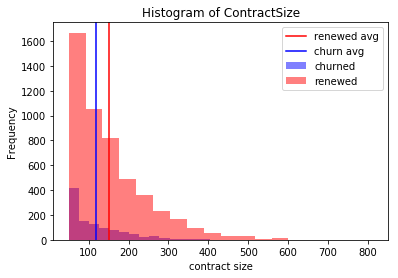

In [16]:
import numpy as np
bins=int(np.sqrt(len(data['contractSize'].unique())))
plt.hist(data[data['churn']==1]['contractSize'], bins, alpha=0.5,color='blue', label='churned')
plt.hist(data[data['churn']==0]['contractSize'], bins, alpha=0.5, color='red',label="renewed")

avg_churn_contractsize = round(data[data['churn']==1]['contractSize'].mean(),2)
avg_didnt_churn_contractsize = round(data[data['churn']==0]['contractSize'].mean(),2)
plt.axvline(data[data['churn']==0]['contractSize'].mean(),color='red',label="renewed avg")
plt.axvline(data[data['churn']==1]['contractSize'].mean(),color='blue',label="churn avg")
print('Avg contract size for those who churned: '+str(avg_churn_contractsize))
print('Avg contract size for those who renewed: '+str(avg_didnt_churn_contractsize))
plt.legend(loc='upper right')
plt.title('Histogram of ContractSize')
plt.xlabel('contract size')
plt.ylabel('Frequency')
plt.savefig('contractSize.png')
plt.show()

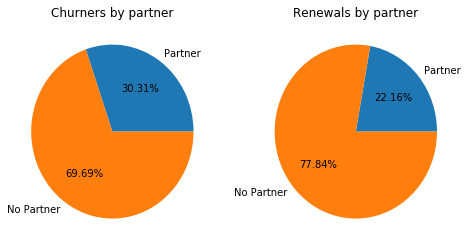

In [25]:
churners_c = churners[['accountID','churn','partnerInvolved']].drop_duplicates()
non_churners_c = non_churners[['accountID','churn','partnerInvolved']].drop_duplicates()


partner_churn = round(100*churners_c['partnerInvolved'].sum()/len(churners_c),2)
no_partner_churn = 100-partner_churn
partner_renew = round(100*non_churners_c['partnerInvolved'].sum()/len(non_churners_c),2)
no_partner_renew = 100-partner_renew

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        return '{p:.2f}%'.format(p=pct)
    return my_autopct

plt.figure(figsize=plt.figaspect(0.5))
plt.subplot(1,2,1)
plt.pie([partner_churn,no_partner_churn],labels=['Partner','No Partner'],autopct=make_autopct([partner_churn,no_partner_churn]))
plt.title('Churners by partner')
plt.subplot(1,2,2)
plt.pie([partner_renew,no_partner_renew],labels=['Partner','No Partner'],autopct=make_autopct([partner_renew,no_partner_renew]))
plt.title('Renewals by partner')
plt.savefig('Partner_Pie.png')
plt.show()

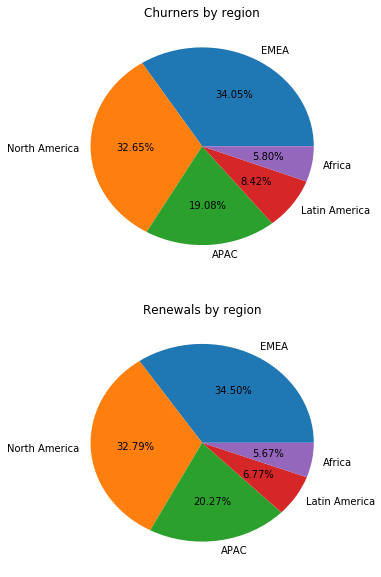

In [36]:
churners_regions = 100*churners['region'].value_counts()/len(churners)
renewers_region = 100*non_churners['region'].value_counts()/len(non_churners)

plt.figure(figsize=(5,10))
plt.subplot(2,1,1)
plt.pie(churners_regions,labels=churners_regions.index,autopct=make_autopct(churners_regions))
plt.title('Churners by region')
plt.subplot(2,1,2)
plt.pie(renewers_region,labels=churners_regions.index,autopct=make_autopct(renewers_region))
plt.title('Renewals by region')
plt.savefig('region_pie.png')
plt.show()

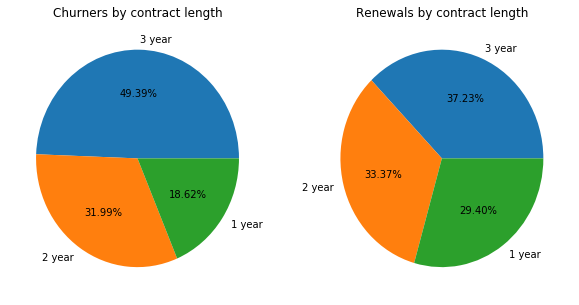

In [35]:
churners_length = 100*churners['contractLength'].value_counts()/len(churners)
renewers_length = 100*non_churners['contractLength'].value_counts()/len(non_churners)


plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.pie(churners_length,labels=[str(i)+" year" for i in churners_length.index],autopct=make_autopct(churners_length))
plt.title('Churners by contract length')
plt.subplot(1,2,2)
plt.pie(renewers_length,labels=[str(i)+" year" for i in churners_length.index],autopct=make_autopct(renewers_length))
plt.title('Renewals by contract length')
plt.savefig('length_pie.png')
plt.show()